#### Imports and Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Reading CSV from link
def read_csv_from_link(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path,delimiter="\t",error_bad_lines=False, header=None)
    return df

In [4]:
# Loading All Data
tamil_train = read_csv_from_link('https://drive.google.com/file/d/15auwrFAlq52JJ61u7eSfnhT9rZtI5sjk/view?usp=sharing')
tamil_dev = read_csv_from_link('https://drive.google.com/file/d/1Jme-Oftjm7OgfMNLKQs1mO_cnsQmznRI/view?usp=sharing')
malayalam_train = read_csv_from_link('https://drive.google.com/file/d/13JCCr-IjZK7uhbLXeufptr_AxvsKinVl/view?usp=sharing')
malayalam_dev = read_csv_from_link('https://drive.google.com/file/d/1J0msLpLoM6gmXkjC6DFeQ8CG_rrLvjnM/view?usp=sharing')
kannada_train = read_csv_from_link('https://drive.google.com/file/d/1BFYF05rx-DK9Eb5hgoIgd6EcB8zOI-zu/view?usp=sharing')
kannada_dev = read_csv_from_link('https://drive.google.com/file/d/1V077dMQvscqpUmcWTcFHqRa_vTy-bQ4H/view?usp=sharing')

In [5]:
# Mal Preprocess
kannada_train = kannada_train.iloc[:, 0:2]
kannada_train = kannada_train.rename(columns={0: "text", 1: "label"})
# Stats
kannada_train['label'] = pd.Categorical(kannada_train.label)
# Mal Preprocess
kannada_dev = kannada_dev.iloc[:, 0:2]
kannada_dev = kannada_dev.rename(columns={0: "text", 1: "label"})
# Stats
kannada_dev['label'] = pd.Categorical(kannada_dev.label)

### Load Model

In [6]:
import torch

In [6]:
print("GPU Nos: {}".format(torch.cuda.device_count()))
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))

# Change Device - CPU/GPU-0/GPU-1
torch.cuda.set_device(0)
device = 'cuda'
device = device if torch.cuda.is_available() else 'cpu'

GPU Nos: 2
Tesla P100-PCIE-12GB
Tesla P100-PCIE-16GB


## Enter Path of Saved model here in torch.load()

In [9]:
saved_model_filenames = [
    'XLMroberta_large_kannada.pth',
    'MURIL_cased_temp_kannada.pth',
    'Indic_bert_kannada.pth',
    'Indic_bert_kannada_weighted.pth',
    'MURIL_cased_temp_kannada_weighted.pth',
    'XLMroberta_large_kannada_weighted.pth',
    'Mbert_base_cased_kannada.pth',
    'Distilbert_m_base_cased_kannada.pth',
    'XLMroberta_custom_pretrained_kannada.pth',
    'Mbert_base_cased_kannada_weighted.pth',
    'Distilbert_m_base_cased_kannada_weighted.pth',
    'XLMroberta_custom_pretrained_kannada_weighted.pth'
]

In [10]:
model_pretrained_keys = [
    'xlm-roberta-large',
    "simran-kh/muril-cased-temp",
    'ai4bharat/indic-bert',
    'ai4bharat/indic-bert',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-large',
    'bert-base-multilingual-cased',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
]

In [11]:
tokenizers = []
models = []

In [13]:
# Loading Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification

for model_name, pretrained_key in zip(saved_model_filenames, model_pretrained_keys):
    
    if pretrained_key == 'distilbert-base-multilingual-cased':
        tokenizer = BertTokenizer.from_pretrained(pretrained_key)
        model = BertForSequenceClassification.from_pretrained(pretrained_key, num_labels=6)
    else:
        tokenizer = AutoTokenizer.from_pretrained(pretrained_key)
        model = AutoModelForSequenceClassification.from_pretrained(pretrained_key, num_labels=6)
        
    state_dict = torch.load(os.path.join('../../finetuned_models/', model_name))
    model.load_state_dict(state_dict)
    model.eval()
    
    models.append(model)
    tokenizers.append(tokenizer)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

### Dataset Stuff

In [13]:
label_mapping = {
    'Not_offensive': 0, 
    'not-Kannada': 1, 
    'Offensive_Targeted_Insult_Other': 2, 
    'Offensive_Targeted_Insult_Group': 3, 
    'Offensive_Untargetede': 4, 
    'Offensive_Targeted_Insult_Individual': 5
}

# Collecting Text and Labels
train_batch_sentences = list(kannada_train['text'])
train_batch_labels =  [label_mapping[x] for x in kannada_train['label']]
dev_batch_sentences = list(kannada_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in kannada_dev['label']]

# Convert to Tensor
train_encodings = [tokenizer(train_batch_sentences, padding='max_length', truncation=True, max_length=64, return_tensors="pt") for tokenizer in tokenizers]
train_labels = torch.tensor(train_batch_labels)
dev_encodings = [tokenizer(dev_batch_sentences, padding='max_length', truncation=True, max_length=64, return_tensors="pt") for tokenizer in tokenizers]
dev_labels = torch.tensor(dev_batch_labels)

NameError: name 'tokenizers' is not defined

In [15]:
# Dataset
from torch.utils.data import Dataset

class Kannada_Offensive_Dataset(Dataset):
    def __init__(self, encodings, labels, bpe = False):
        self.encodings = encodings
        self.labels = labels
        self.is_bpe_tokenized = bpe

    def __getitem__(self, idx):
        if not self.is_bpe_tokenized:
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        else:
            item = {
                'input_ids': torch.LongTensor(self.encodings[idx].ids),
                'attention_mask': torch.LongTensor(self.encodings[idx].attention_mask)
            }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
# Defining Datasets
train_datasets = [Kannada_Offensive_Dataset(tenc, train_labels, bpe = False) for tenc in train_encodings]
dev_datasets = [Kannada_Offensive_Dataset(denc, dev_labels, bpe = False) for denc in dev_encodings]

### Get predictions

In [17]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
all_dev_preds = []

for model, dev_dataset in tqdm(zip(models, dev_datasets), total = len(models)):
    model.to(device)
    # Dataloaders
    dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

    dev_preds = []
    with torch.no_grad():
        for batch in tqdm(dev_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            for logits in outputs[1].cpu().numpy():
                dev_preds.append(np.exp(logits)/np.sum(np.exp(logits)))
    
    # Add All together
    all_dev_preds.append(dev_preds)

/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


#### SAVE PREDS

In [18]:
for dev_preds, modelname in zip(all_dev_preds, saved_model_filenames):
    np.save('../../model_prediction_probs/preds_'+modelname+'.npy', dev_preds)

#### Load preds

In [7]:
model_pretrained_keys = [
    'xlm-roberta-base',
    'distilbert-base-multilingual-cased',
    'ai4bharat/indic-bert',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-large',    
    'bert-base-multilingual-cased',
    'bert-base-multilingual-cased',
    'xlm-roberta-large',
    'ai4bharat/indic-bert',
    "simran-kh/muril-cased-temp",
]

In [18]:
import os
a = [x for x in os.listdir('../../model_prediction_probs/') if 'anna' in x and 'llate' not in x and 'only' not in x and 'fusion' not in x and x.startswith('pre') and 'self' not in x]
len(a)

12

In [20]:
load_model_filenames = [
    'XLMroberta_custom_pretrained_kannada.pth',
    'Distilbert_m_base_cased_kannada_weighted.pth',
    'Indic_bert_kannada_weighted.pth',
    'Distilbert_m_base_cased_kannada.pth',
    'XLMroberta_custom_pretrained_kannada_weighted.pth',
    'MURIL_cased_temp_kannada.pth',
    'XLMroberta_large_kannada_weighted.pth',
    'Mbert_base_cased_kannada.pth',
    'Mbert_base_cased_kannada_weighted.pth',
    'XLMroberta_large_kannada.pth',
    'Indic_bert_kannada.pth',
    'MURIL_cased_temp_kannada_weighted.pth',
]

model_pretrained_keys = [
    'xlm-roberta-base',
    'distilbert-base-multilingual-cased',
    'ai4bharat/indic-bert',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base',
    "simran-kh/muril-cased-temp",
    'xlm-roberta-large',    
    'bert-base-multilingual-cased',
    'bert-base-multilingual-cased',
    'xlm-roberta-large',
    'ai4bharat/indic-bert',
    "simran-kh/muril-cased-temp",
]

print(len(load_model_filenames))

all_dev_preds = []
for modelname in load_model_filenames:
    all_dev_preds.append(np.load('../../model_prediction_probs/preds_'+modelname+'.npy'))

12


In [21]:
from sklearn.metrics import classification_report, f1_score

In [25]:
label_mapping = {
    'Not_offensive': 0, 
    'not-Kannada': 1, 
    'Offensive_Targeted_Insult_Other': 2, 
    'Offensive_Targeted_Insult_Group': 3, 
    'Offensive_Untargetede': 4, 
    'Offensive_Targeted_Insult_Individual': 5
}

# Collecting Text and Labels
train_batch_sentences = list(kannada_train['text'])
train_batch_labels =  [label_mapping[x] for x in kannada_train['label']]
dev_batch_sentences = list(kannada_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in kannada_dev['label']]

for dev_preds, mn in zip(all_dev_preds, load_model_filenames):
    final_dev_preds = np.argmax(dev_preds, axis = 1)
    y_true = dev_batch_labels
    y_pred = final_dev_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

XLMroberta_custom_pretrained_kannada.pth
                                      precision    recall  f1-score   support

                       Not_offensive       0.79      0.80      0.80       426
                         not-Kannada       0.74      0.81      0.77       191
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        16
     Offensive_Targeted_Insult_Group       0.37      0.49      0.42        45
               Offensive_Untargetede       0.05      0.03      0.04        33
Offensive_Targeted_Insult_Individual       0.63      0.59      0.61        66

                            accuracy                           0.72       777
                           macro avg       0.43      0.45      0.44       777
                        weighted avg       0.69      0.72      0.70       777

Distilbert_m_base_cased_kannada_weighted.pth
                                      precision    recall  f1-score   support

                       Not_offensive       0.77     

/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Averaging Ensemble

In [10]:
all_dev_preds = np.array(all_dev_preds)

# Initialise Weights
w = np.ones(all_dev_preds.shape[0])
softmax_w = np.exp(w)/np.sum(np.exp(w))

weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

In [14]:
label_mapping = {
    'Not_offensive': 0, 
    'not-Kannada': 1, 
    'Offensive_Targeted_Insult_Other': 2, 
    'Offensive_Targeted_Insult_Group': 3, 
    'Offensive_Untargetede': 4, 
    'Offensive_Targeted_Insult_Individual': 5
}

# Collecting Text and Labels
train_batch_sentences = list(kannada_train['text'])
train_batch_labels =  [label_mapping[x] for x in kannada_train['label']]
dev_batch_sentences = list(kannada_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in kannada_dev['label']]

In [15]:
y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.85      0.81       426
                         not-Kannada       0.74      0.84      0.79       191
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        16
     Offensive_Targeted_Insult_Group       0.42      0.31      0.36        45
               Offensive_Untargetede       0.43      0.09      0.15        33
Offensive_Targeted_Insult_Individual       0.65      0.55      0.60        66

                            accuracy                           0.74       777
                           macro avg       0.50      0.44      0.45       777
                        weighted avg       0.71      0.74      0.72       777



### Optimising with GA

 The best solution found:                                                                           
 [2.45755889 1.81199597 0.46211092 1.63414761 2.65716323 1.27402854
 4.01661441 3.30297596 2.12425989 0.70285799 0.745588   3.20394856]

 Objective function:
 0.46137094358593855


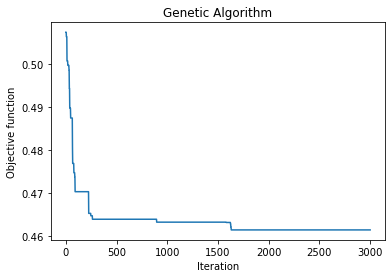

In [23]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    softmax_w = np.exp(X)/np.sum(np.exp(X))
    weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
    weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
    final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

    y_true = dev_batch_labels
    y_pred = final_dev_preds
    score = f1_score(y_true, y_pred, average='macro')
    return 1-score

varbound=np.array([[0, 5]]*all_dev_preds.shape[0])

model=ga(function=f,dimension=all_dev_preds.shape[0],variable_type='real',variable_boundaries=varbound)

model.run()

In [24]:
convergence=model.report
solution=model.output_dict

In [25]:
solution

{'variable': array([2.45755889, 1.81199597, 0.46211092, 1.63414761, 2.65716323,
        1.27402854, 4.01661441, 3.30297596, 2.12425989, 0.70285799,
        0.745588  , 3.20394856]),
 'function': 0.46137094358593855}

In [ ]:
X = solution['variable']

In [20]:
import pickle
saved_model_filename = 'GA_v1_kannada'

with open("../../dev_preds/weights_" + saved_model_filename + ".pickle", 'rb') as handle:
    mw = pickle.load(handle)
    
X = [mw[index][0] for index in mw.keys()]

In [21]:
X

[2.4575588857477992,
 1.8119959704070476,
 0.462110920903549,
 1.6341476131375288,
 2.65716323320213,
 1.2740285448075563,
 4.016614405001666,
 3.302975964858024,
 2.124259887478466,
 0.7028579920165603,
 0.7455879960046707,
 3.2039485588581016]

In [22]:
softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

In [23]:
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.85      0.82       426
                         not-Kannada       0.76      0.82      0.79       191
     Offensive_Targeted_Insult_Other       0.75      0.19      0.30        16
     Offensive_Targeted_Insult_Group       0.50      0.36      0.42        45
               Offensive_Untargetede       0.46      0.18      0.26        33
Offensive_Targeted_Insult_Individual       0.68      0.62      0.65        66

                            accuracy                           0.75       777
                           macro avg       0.66      0.50      0.54       777
                        weighted avg       0.74      0.75      0.74       777



In [24]:
f1_score(y_true, y_pred, average='macro')

0.5386290564140614

### Save stuff

In [25]:
saved_model_filename = 'GA_v1_kannada'
np.savetxt("../../dev_preds/" + saved_model_filename + ".csv", final_dev_preds, delimiter=",")

In [26]:
np.save("../../model_prediction_probs/"+saved_model_filename+".npy", weighted_dev_preds)

In [1]:
a = {x:(y,z) for x, y, z in zip(load_model_filenames, np.array(solution['variable']), model_pretrained_keys)}

NameError: name 'load_model_filenames' is not defined

In [2]:
import pickle
with open("../../dev_preds/weights_" + saved_model_filename + ".pickle", 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'saved_model_filename' is not defined